In [25]:
import sparknlp
import logging
sparknlp.start()
import numpy as np

from sparknlp import *
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, udf, avg, count
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName('Spark-Sentiment').getOrCreate()
logger = spark.sparkContext._jvm.org.apache.log4j
logger.LogManager.getLogger("org.apache.spark.scheduler").setLevel(logger.Level.ERROR)
logging.getLogger("py4j").setLevel(logging.ERROR)
spark.sparkContext.setLogLevel("ERROR")

In [3]:
spark.conf.set("spark.hadoop.google.cloud.auth.service.account.enable", "true")
spark.conf.set("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "path/to/your/credentials.json")

### Pipeline Construction

In [4]:
tokenizer = Tokenizer(inputCol="review_body", outputCol="review_body_words")
remover = StopWordsRemover(inputCol="review_body_words", outputCol="review_body_words_filtered")
hashingTF = HashingTF(inputCol="review_body_words_filtered", outputCol="hashingTF_features")
idf = IDF(inputCol="hashingTF_features", outputCol="idf_features")
labelIndexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_label")

pipeline = Pipeline(stages=[tokenizer,remover,hashingTF,idf,labelIndexer])

### EDA

In [4]:
df_apparel = spark.read.format("csv").option("header", "true").\
                option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Apparel_v1_00.tsv")
df_apparel = df_apparel.dropna().withColumn("star_rating",df_apparel.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

In [5]:
df_apparel.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|sentiment|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|         US|   32158956|R1KKOXHNI8MSXU|B01KL6O72Y|      24485154|Easy Tool Stainle...|         Apparel|          4|            0|          0|   N|                Y|★ THESE REALLY DO...|These Really Do W...| 2013-01-14| positive|
|         US|    2714559|R26SP2OPDK4HT7|B01ID3ZS5W|     363128556|V28 Women Cowl

In [41]:
df_apparel.groupby("total_votes").count().show()

+-----------+-----+
|total_votes|count|
+-----------+-----+
|        125|   33|
|          7|28447|
|         51|  370|
|        124|   44|
|        307|    4|
|        169|   17|
|        544|    1|
|        334|    7|
|        205|    3|
|         15| 5526|
|         54|  321|
|        234|   10|
|        232|    8|
|        155|   16|
|        132|   28|
|        154|   20|
|        317|    2|
|        388|    2|
|         11|11016|
|        101|   79|
+-----------+-----+
only showing top 20 rows



In [14]:
df_apparel.filter(df_apparel.vine == 'N').select(avg(df_apparel.star_rating)).show()

+-----------------+
| avg(star_rating)|
+-----------------+
|4.105138750516057|
+-----------------+



In [18]:
df_apparel.filter(df_apparel.vine == 'Y').count()

2336

In [15]:
df_apparel.filter(df_apparel.vine == 'Y').select(avg(df_apparel.star_rating)).show()

+-----------------+
| avg(star_rating)|
+-----------------+
|4.248287671232877|
+-----------------+



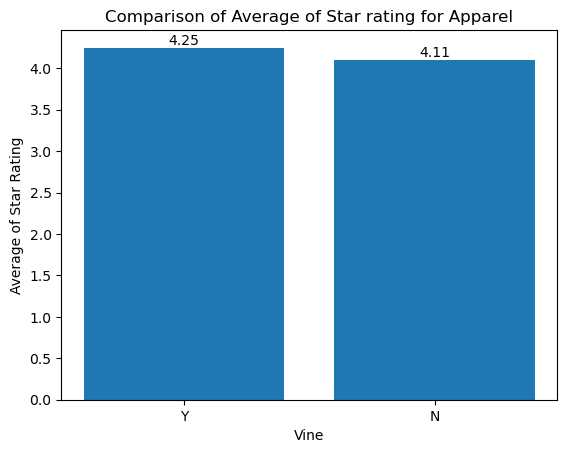

In [60]:
agg_data = df_apparel.groupBy("Vine").agg(avg("star_rating")).collect()

# Extract the data from the result
labels = [row.Vine for row in agg_data]
values = [row['avg(star_rating)'] for row in agg_data]

# Generate the bar plot
plt.bar(labels, values)
plt.xlabel("Vine")
plt.ylabel("Average of Star Rating")
plt.title("Comparison of Average of Star rating for Apparel")

for i, v in enumerate(values):
    plt.text(i, v, str(round(v,2)), ha='center', va='bottom')

plt.show()

In [52]:
pie_data = df_toys.groupBy("vine").agg(count("*")).collect()

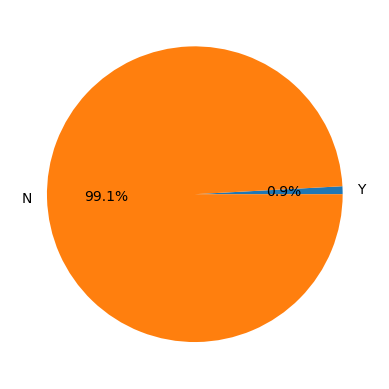

In [53]:
labels = [row.vine for row in pie_data]
values = [row['count(1)']  for row in pie_data]

# Generate the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.show()

In [9]:
df_apparel.groupby("star_rating").count().orderBy(["count"], ascending=[0]).show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          5|3319865|
|          4|1147055|
|          3| 623413|
|          1| 445373|
|          2| 369563|
+-----------+-------+



In [27]:
df_automotive = spark.read.format("csv").option("header", "true").\
                option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Automotive_v1_00.tsv")
df_automotive = df_automotive.dropna().withColumn("star_rating",df_automotive.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))


In [11]:
df_automotive.groupby("star_rating").count().orderBy(["count"], ascending=[0]).show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          5|2300096|
|          4| 526558|
|          1| 299807|
|          3| 239844|
|          2| 147740|
+-----------+-------+



In [31]:
df_beauty = spark.read.format("csv").option("header", "true").\
            option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Beauty_v1_00.tsv")
df_beauty = df_beauty.dropna().withColumn("star_rating",df_beauty.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

In [13]:
df_beauty.groupby("star_rating").count().orderBy(["count"], ascending=[0]).show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          5|3254274|
|          4| 741326|
|          1| 456805|
|          3| 398355|
|          2| 263973|
+-----------+-------+



In [34]:
df_electronics = spark.read.format("csv").option("header", "true").\
                 option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Electronics_v1_00.tsv")
df_electronics = df_electronics.dropna().withColumn("star_rating",df_electronics.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

In [15]:
df_electronics.groupby("star_rating").count().orderBy(["count"], ascending=[0]).show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          5|1781031|
|          4| 536797|
|          1| 358085|
|          3| 238575|
|          2| 179172|
+-----------+-------+



In [42]:
df_shoes = spark.read.format("csv").option("header", "true").\
                 option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Shoes_v1_00.tsv")
df_shoes = df_shoes.dropna().withColumn("star_rating",df_shoes.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

In [17]:
df_shoes.groupby("star_rating").count().orderBy(["count"], ascending=[0]).show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          5|2639539|
|          4| 847692|
|          3| 404153|
|          2| 242819|
|          1| 232121|
+-----------+-------+



In [45]:
df_pet_products = spark.read.format("csv").option("header", "true").\
                  option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Pet_Products_v1_00.tsv")
df_pet_products = df_pet_products.dropna().withColumn("star_rating",df_pet_products.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

In [23]:
df_pet_products.groupby("star_rating").count().orderBy(["count"], ascending=[0]).show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          5|1645283|
|          4| 381242|
|          1| 248820|
|          3| 216618|
|          2| 151278|
+-----------+-------+



In [48]:
df_sports = spark.read.format("csv").option("header", "true").\
                  option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Sports_v1_00.tsv")
df_sports = df_sports.dropna().withColumn("star_rating",df_sports.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

In [25]:
df_sports.groupby("star_rating").count().orderBy(["count"], ascending=[0]).show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          5|3039747|
|          4| 836577|
|          3| 380434|
|          1| 362894|
|          2| 229348|
+-----------+-------+



In [49]:
df_toys = spark.read.format("csv").option("header", "true").\
                option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Toys_v1_00.tsv")
df_toys = df_toys.dropna().withColumn("star_rating",df_toys.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

In [27]:
df_toys.groupby("star_rating").count().orderBy(["count"], ascending=[0]).show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          5|3076420|
|          4| 769630|
|          1| 399427|
|          3| 387668|
|          2| 230352|
+-----------+-------+



In [12]:
from pyspark.sql.functions import mean

In [18]:
avg_rating_apparel = df_apparel.agg(mean('star_rating')).collect()[0][0]
avg_rating_automotive = df_automotive.agg(mean('star_rating')).collect()[0][0]
avg_rating_beauty = df_beauty.agg(mean('star_rating')).collect()[0][0]
avg_rating_electronics = df_electronics.agg(mean('star_rating')).collect()[0][0]
avg_rating_shoes = df_shoes.agg(mean('star_rating')).collect()[0][0]
avg_rating_sports = df_sports.agg(mean('star_rating')).collect()[0][0]
avg_rating_toys = df_toys.agg(mean('star_rating')).collect()[0][0]
avg_rating_pet_products = df_pet_products.agg(mean('star_rating')).collect()[0][0]

In [26]:
schema = StructType([
    StructField("Dataset_Name", StringType(), True),
    StructField("Rating_Average", FloatType(), True),
])

In [27]:
avg_data = [("Apparel", avg_rating_apparel), ("Automative", avg_rating_automotive), ("Beauty", avg_rating_beauty), ("Electronics", avg_rating_electronics), ("Shoes", avg_rating_shoes), ("Sports", avg_rating_sports), ("Toys", avg_rating_toys), ("Pet_products", avg_rating_pet_products)]

In [28]:
df_avg_data = spark.createDataFrame(avg_data, schema=schema)

In [31]:
import matplotlib.pyplot as plt

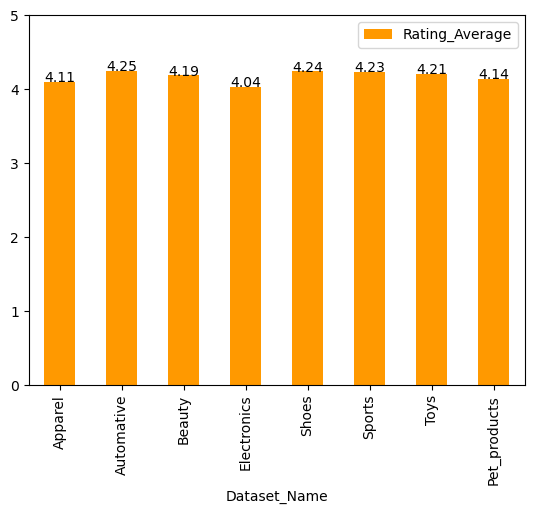

In [38]:
pdf_avg_data  = df_avg_data .toPandas()
ax = pdf_avg_data.plot(kind='bar', x='Dataset_Name', y = 'Rating_Average', color='#FF9900')

for i, v in enumerate(pdf_avg_data['Rating_Average']):
    ax.text(i, v, str(round(v, 2)), color='black', ha='center')

ax.set_ylim([0, 5])

plt.show()

In [ ]:
df_apparel.show(5)

### Dataset cleaning and spliting

In [6]:
## Apparel
df_apparel = spark.read.format("csv").option("header", "true").\
                option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Apparel_v1_00.tsv")
df_apparel = df_apparel.dropna().withColumn("star_rating",df_apparel.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_apparel = pipeline.fit(df_apparel).transform(df_apparel).select('review_id','product_id','product_title','sentiment_label','idf_features')
trainData_apparel, testData_apparel = result_apparel.randomSplit([0.7,0.3])

lgr_apparel = LogisticRegression(maxIter=10, featuresCol = 'idf_features', labelCol='sentiment_label').fit(trainData_apparel)
lgr_predictions_apparel = lgr_apparel.transform(testData_apparel)
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="prediction", metricName="accuracy")
lgr_accuracy_apparel = evaluator.evaluate(lgr_predictions_apparel)
print("Accuracy = %g" % (lgr_accuracy_apparel))

Accuracy = 0.86899


In [ ]:
df_apparel.groupby("").count().orderBy(["count"], ascending=[0]).show(10)

In [7]:
## Automotive
df_automotive = spark.read.format("csv").option("header", "true").\
                option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Automotive_v1_00.tsv")
df_automotive = df_automotive.dropna().withColumn("star_rating",df_automotive.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_automotive = pipeline.fit(df_automotive).transform(df_automotive).select('review_id','product_id','product_title','sentiment_label','idf_features')
trainData_automotive, testData_automotive = result_automotive.randomSplit([0.7,0.3])

lgr_automotive = LogisticRegression(maxIter=10, featuresCol = 'idf_features', labelCol='sentiment_label').fit(trainData_automotive)
lgr_predictions_automotive = lgr_automotive.transform(testData_automotive)
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="prediction", metricName="accuracy")
lgr_accuracy_automotive = evaluator.evaluate(lgr_predictions_automotive)
print("Accuracy = %g" % (lgr_accuracy_automotive))

Accuracy = 0.874957


In [8]:
## Beauty
df_beauty = spark.read.format("csv").option("header", "true").\
            option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Beauty_v1_00.tsv")
df_beauty = df_beauty.dropna().withColumn("star_rating",df_beauty.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_beauty = pipeline.fit(df_beauty).transform(df_beauty).select('review_id','product_id','product_title','sentiment_label','idf_features')
trainData_beauty, testData_beauty = result_beauty.randomSplit([0.7,0.3])

lgr_beauty = LogisticRegression(maxIter=10, featuresCol = 'idf_features', labelCol='sentiment_label').fit(trainData_beauty)
lgr_predictions_beauty = lgr_beauty.transform(testData_beauty)
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="prediction", metricName="accuracy")
lgr_accuracy_beauty = evaluator.evaluate(lgr_predictions_beauty)
print("Accuracy = %g" % (lgr_accuracy_beauty))

Accuracy = 0.874964


In [9]:
## Electronics
df_electronics = spark.read.format("csv").option("header", "true").\
                 option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Electronics_v1_00.tsv")
df_electronics = df_electronics.dropna().withColumn("star_rating",df_electronics.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_electronics = pipeline.fit(df_electronics).transform(df_electronics).select('review_id','product_id','product_title','sentiment_label','idf_features')
trainData_electronics, testData_electronics = result_electronics.randomSplit([0.7,0.3])

lgr_electronics = LogisticRegression(maxIter=10, featuresCol = 'idf_features', labelCol='sentiment_label').fit(trainData_electronics)
lgr_predictions_electronics = lgr_electronics.transform(testData_electronics)
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="prediction", metricName="accuracy")
lgr_accuracy_electronics = evaluator.evaluate(lgr_predictions_electronics)
print("Accuracy = %g" % (lgr_accuracy_electronics))

Accuracy = 0.870014


In [10]:
## Shoes
df_shoes = spark.read.format("csv").option("header", "true").\
                 option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Shoes_v1_00.tsv")
df_shoes = df_shoes.dropna().withColumn("star_rating",df_shoes.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_shoes = pipeline.fit(df_shoes).transform(df_shoes).select('review_id','product_id','product_title','sentiment_label','idf_features')
trainData_shoes, testData_shoes = result_shoes.randomSplit([0.7,0.3])

lgr_shoes = LogisticRegression(maxIter=10, featuresCol = 'idf_features', labelCol='sentiment_label').fit(trainData_shoes)
lgr_predictions_shoes = lgr_shoes.transform(testData_shoes)
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="prediction", metricName="accuracy")
lgr_accuracy_shoes = evaluator.evaluate(lgr_predictions_shoes)
print("Accuracy = %g" % (lgr_accuracy_shoes))

Accuracy = 0.877858


In [11]:
## Pet Products
df_pet_products = spark.read.format("csv").option("header", "true").\
                  option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Pet_Products_v1_00.tsv")
df_pet_products = df_pet_products.dropna().withColumn("star_rating",df_pet_products.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_pet_products = pipeline.fit(df_pet_products).transform(df_pet_products).select('review_id','product_id','product_title','sentiment_label','idf_features')
trainData_pet_products, testData_pet_products = result_pet_products.randomSplit([0.7,0.3])

lgr_pet_products = LogisticRegression(maxIter=10, featuresCol = 'idf_features', labelCol='sentiment_label').fit(trainData_pet_products)
lgr_predictions_pet_products = lgr_pet_products.transform(testData_pet_products)
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="prediction", metricName="accuracy")
lgr_accuracy_pet_products = evaluator.evaluate(lgr_predictions_pet_products)
print("Accuracy = %g" % (lgr_accuracy_pet_products))

Accuracy = 0.8608


In [12]:
## Sports
df_sports = spark.read.format("csv").option("header", "true").\
                  option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Sports_v1_00.tsv")
df_sports = df_sports.dropna().withColumn("star_rating",df_sports.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_sports = pipeline.fit(df_sports).transform(df_sports).select('review_id','product_id','product_title','sentiment_label','idf_features')
trainData_sports, testData_sports = result_sports.randomSplit([0.7,0.3])

lgr_sports = LogisticRegression(maxIter=10, featuresCol = 'idf_features', labelCol='sentiment_label').fit(trainData_sports)
lgr_predictions_sports = lgr_sports.transform(testData_sports)
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="prediction", metricName="accuracy")
lgr_accuracy_sports = evaluator.evaluate(lgr_predictions_sports)
print("Accuracy = %g" % (lgr_accuracy_sports))

Accuracy = 0.87842


In [13]:
## Toys
df_toys = spark.read.format("csv").option("header", "true").\
                option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Toys_v1_00.tsv")
df_toys = df_toys.dropna().withColumn("star_rating",df_toys.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_toys = pipeline.fit(df_toys).transform(df_toys).select('review_id','product_id','product_title','sentiment_label','idf_features')
trainData_toys, testData_toys = result_toys.randomSplit([0.7,0.3])

lgr_toys = LogisticRegression(maxIter=10, featuresCol = 'idf_features', labelCol='sentiment_label').fit(trainData_toys)
lgr_predictions_toys = lgr_toys.transform(testData_toys)
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="prediction", metricName="accuracy")
lgr_accuracy_toys = evaluator.evaluate(lgr_predictions_toys)
print("Accuracy = %g" % (lgr_accuracy_toys))

Accuracy = 0.886941


In [13]:
from pyspark.ml.util import MLWritable

bucket_name = "msca-bdp-student-gcs"

model_folder_path_apparel = "Group4_Project_Data/models/LGR_apparel"
model_gcs_path_apparel = f"gs://{bucket_name}/{model_folder_path_apparel}"
lgr_apparel.write().overwrite().save(model_gcs_path_apparel)

model_folder_path_automotive = "Group4_Project_Data/models/LGR_automotive"
model_gcs_path_automotive = f"gs://{bucket_name}/{model_folder_path_automotive}"
lgr_automotive.write().overwrite().save(model_gcs_path_automotive)

model_folder_path_beauty = "Group4_Project_Data/models/LGR_beauty"
model_gcs_path_beauty = f"gs://{bucket_name}/{model_folder_path_beauty}"
lgr_beauty.write().overwrite().save(model_gcs_path_beauty)

model_folder_path_electronics = "Group4_Project_Data/models/LGR_electronics"
model_gcs_path_electronics = f"gs://{bucket_name}/{model_folder_path_electronics}"
lgr_electronics.write().overwrite().save(model_gcs_path_electronics)

model_folder_path_shoes = "Group4_Project_Data/models/LGR_shoes"
model_gcs_path_shoes = f"gs://{bucket_name}/{model_folder_path_shoes}"
lgr_shoes.write().overwrite().save(model_gcs_path_shoes)

model_folder_path_pet_products = "Group4_Project_Data/models/LGR_pet_products"
model_gcs_path_pet_products = f"gs://{bucket_name}/{model_folder_path_pet_products}"
lgr_pet_products.write().overwrite().save(model_gcs_path_pet_products)

model_folder_path_sports = "Group4_Project_Data/models/LGR_sports"
model_gcs_path_sports = f"gs://{bucket_name}/{model_folder_path_sports}"
lgr_sports.write().overwrite().save(model_gcs_path_sports)

model_folder_path_toys = "Group4_Project_Data/models/LGR_toys"
model_gcs_path_toys = f"gs://{bucket_name}/{model_folder_path_toys}"
lgr_toys.write().overwrite().save(model_gcs_path_toys)

In [15]:
model_path_apparel = 'gs://msca-bdp-student-gcs/Group4_Project_Data/models/LGR_apparel'
lgr_apparel = logisticRegression.load(model_path_apparel)

model_path_automotive = 'gs://msca-bdp-student-gcs/Group4_Project_Data/models/LGR_automotive'
lgr_automotive = logisticRegression.load(model_path_automotive)

model_path_beauty = 'gs://msca-bdp-student-gcs/Group4_Project_Data/models/LGR_beauty'
lgr_beauty = logisticRegression.load(model_path_beauty)

model_path_electronics = 'gs://msca-bdp-student-gcs/Group4_Project_Data/models/LGR_electronics'
lgr_electronics = logisticRegression.load(model_path_electronics)

model_path_shoes = 'gs://msca-bdp-student-gcs/Group4_Project_Data/models/LGR_shoes'
lgr_shoes = logisticRegression.load(model_path_shoes)

model_path_pet_products = 'gs://msca-bdp-student-gcs/Group4_Project_Data/models/LGR_pet_products'
lgr_pet_products = logisticRegression.load(model_path_pet_products)

model_path_sports = 'gs://msca-bdp-student-gcs/Group4_Project_Data/models/LGR_sports'
lgr_sports = logisticRegression.load(model_path_sports)

model_path_toys = 'gs://msca-bdp-student-gcs/Group4_Project_Data/models/LGR_toys'
lgr_toys = logisticRegression.load(model_path_toys)

NameError: name 'logisticRegression' is not defined

### Ensemble the models using soft voting

#### Run trial on personal care dataset to see if there's improvement

In [14]:
schema = StructType([
    StructField("model", StringType(), True),
    StructField("dataset", StringType(), True),
    StructField("accuracy", DoubleType(), True)
])

data = [("LGR Apparel", "Apparel", lgr_accuracy_apparel), 
        ("LGR Automotive", "Automotive", lgr_accuracy_automotive), 
        ("LGR Beauty", "Beauty", lgr_accuracy_beauty),
        ("LGR Electronics", "Electronics", lgr_accuracy_electronics),
        ("LGR Shoes", "Shoes", lgr_accuracy_shoes),
        ("LGR Pet Products", "Pet Products", lgr_accuracy_pet_products),
        ("LGR Sports", "Sports", lgr_accuracy_sports),
        ("LGR Toys", "Toys", lgr_accuracy_toys)]

evaluation = spark.createDataFrame(data, schema)
evaluation.show()

+----------------+------------+------------------+
|           model|     dataset|          accuracy|
+----------------+------------+------------------+
|     LGR Apparel|     Apparel|0.8689896320252585|
|  LGR Automotive|  Automotive|0.8749570887490019|
|      LGR Beauty|      Beauty|0.8749639560064753|
| LGR Electronics| Electronics|0.8700139307727862|
|       LGR Shoes|       Shoes|0.8778581778815395|
|LGR Pet Products|Pet Products|0.8607996170102865|
|      LGR Sports|      Sports|0.8784202720885447|
|        LGR Toys|        Toys| 0.886940973124476|
+----------------+------------+------------------+



Model ensembling with soft voting increases accuracy of predicting sentiment labels based on customer reviews.

In [15]:
testData_apparel.show(2)

+--------------+----------+--------------------+---------------+--------------------+
|     review_id|product_id|       product_title|sentiment_label|        idf_features|
+--------------+----------+--------------------+---------------+--------------------+
|R1002FNYOHWIMQ|B00WRGBZQ8|6 Pairs Of excell...|            1.0|(262144,[40672,44...|
|R1002S5WSJJW8R|B00QEDVXNA|Eminem Rap God Ly...|            1.0|(262144,[33358,46...|
+--------------+----------+--------------------+---------------+--------------------+
only showing top 2 rows



In [ ]:
# Define the string indexer to encode the labels as integers
indexer = StringIndexer(inputCol='label', outputCol='label_idx')
# Define a function to extract the probability of positive class from the logistic regression model
extract_prob = udf(lambda x: float(x[1]), StringType())

test_datasets = [testData_apparel,testData_automotive
                 ,testData_beauty,testData_electronics,testData_shoes,testData_pet_products,testData_sports,testData_toys
                ]
dataset_names = ["Apparel", "Automotive"
                 , "Beauty", "Electronics", "Shoes", "Pet Products", "Sports", "Toys"
                ]

schema = StructType([
    StructField("dataset", StringType(), True),
    StructField("accuracy", DoubleType(), True)
])
ensemble_df = spark.createDataFrame([], schema)

for j, test_data in enumerate(test_datasets):
    pred1 = lgr_apparel.transform(test_data).withColumn('probability1', extract_prob('probability')).select('review_id','sentiment_label','probability1')
    pred2 = lgr_automotive.transform(test_data).withColumn('probability2', extract_prob('probability')).select('review_id','probability2')
    pred3 = lgr_beauty.transform(test_data).withColumn('probability3', extract_prob('probability')).select('review_id','probability3')
    pred4 = lgr_electronics.transform(test_data).withColumn('probability4', extract_prob('probability')).select('review_id','probability4')
    pred5 = lgr_shoes.transform(test_data).withColumn('probability5', extract_prob('probability')).select('review_id','probability5')
    pred6 = lgr_pet_products.transform(test_data).withColumn('probability6', extract_prob('probability')).select('review_id','probability6')
    pred7 = lgr_sports.transform(test_data).withColumn('probability7', extract_prob('probability')).select('review_id','probability7')
    pred8 = lgr_toys.transform(test_data).withColumn('probability8', extract_prob('probability')).select('review_id','probability8')
    
    joined_pred = pred1.join(pred2, on=['review_id'], how='inner').join(pred3, on=['review_id'], how='inner').join(pred4, on=['review_id'], how='inner').join(pred5, on=['review_id'], how='inner').join(pred6, on=['review_id'], how='inner').join(pred7, on=['review_id'], how='inner').join(pred8, on=['review_id'], how='inner')

    col_names = [f'probability{i}' for i in (3,4,5)]
    joined_pred = joined_pred.withColumn('avg_probability', sum([col(c) for c in col_names]) / len(col_names))
    joined_pred = joined_pred.withColumn('predicted_label', udf(lambda x: 1.0 if x > 0.5 else 0.0, DoubleType())('avg_probability'))

    evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="predicted_label", metricName="accuracy")
    dataset = dataset_names[j]
    voting_accuracy = evaluator.evaluate(joined_pred)
    ensemble_df = ensemble_df.union(spark.createDataFrame([(dataset, voting_accuracy)], schema))
ensemble_df.show()

+------------+------------------+
|     dataset|          accuracy|
+------------+------------------+
|     Apparel|0.8510840837500643|
|  Automotive| 0.868461860735809|
|      Beauty|0.8689287432216137|
| Electronics|  0.87826070091736|
|       Shoes|0.8859336698459729|
|Pet Products|0.8506563491996666|
|      Sports|0.8747557972797776|
|        Toys|0.8784651755812415|
+------------+------------------+



In [ ]:
df_camera = spark.read.format("csv").option("header", "true").\
                option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Camera_v1_00.tsv")
df_camera = df_camera.dropna().withColumn("star_rating",df_camera.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_camera = pipeline.fit(df_camera).transform(df_camera)
result_camera = result_camera.select('review_id','product_id','product_title','sentiment_label','idf_features')

trainData_camera, testData_camera = result_camera.randomSplit([0.7,0.3])


df_grocery = spark.read.format("csv").option("header", "true").\
                option("delimiter", "\t").load("gs://msca-bdp-student-gcs/Group4_Project_Data/amazon_reviews_us_Grocery_v1_00.tsv")
df_grocery = df_grocery.dropna().withColumn("star_rating",df_grocery.star_rating.cast('int')).withColumn('sentiment', when(col('star_rating') <= 3, 'negative').otherwise('positive'))

result_grocery = pipeline.fit(df_grocery).transform(df_grocery)
result_grocery = result_grocery.select('review_id','product_id','product_title','sentiment_label','idf_features')

trainData_grocery, testData_grocery = result_grocery.randomSplit([0.7,0.3])


# Define the string indexer to encode the labels as integers
indexer = StringIndexer(inputCol='label', outputCol='label_idx')
# Define a function to extract the probability of positive class from the logistic regression model
extract_prob = udf(lambda x: float(x[1]), StringType())

test_datasets = [testData_camera,testData_grocery]
dataset_names = ["Camera", "Grocery", "Beauty"]

schema = StructType([
    StructField("dataset", StringType(), True),
    StructField("accuracy", DoubleType(), True)
])
evaluate_df = spark.createDataFrame([], schema)

for j, test_data in enumerate(test_datasets):
    pred1 = nb_apparel.transform(test_data).withColumn('probability1', extract_prob('probability')).select('review_id','sentiment_label','probability1')
    pred2 = nb_automotive.transform(test_data).withColumn('probability2', extract_prob('probability')).select('review_id','probability2')
    pred3 = nb_beauty.transform(test_data).withColumn('probability3', extract_prob('probability')).select('review_id','probability3')
    pred4 = nb_electronics.transform(test_data).withColumn('probability4', extract_prob('probability')).select('review_id','probability4')
    pred5 = nb_shoes.transform(test_data).withColumn('probability5', extract_prob('probability')).select('review_id','probability5')
    pred6 = nb_pet_products.transform(test_data).withColumn('probability6', extract_prob('probability')).select('review_id','probability6')
    pred7 = nb_sports.transform(test_data).withColumn('probability7', extract_prob('probability')).select('review_id','probability7')
    pred8 = nb_toys.transform(test_data).withColumn('probability8', extract_prob('probability')).select('review_id','probability8')
    
    joined_pred = pred1.join(pred2, on=['review_id'], how='inner').join(pred3, on=['review_id'], how='inner').join(pred4, on=['review_id'], how='inner') \
                .join(pred5, on=['review_id'], how='inner').join(pred6, on=['review_id'], how='inner').join(pred7, on=['review_id'], how='inner') \
                .join(pred8, on=['review_id'], how='inner')

    col_names = [f'probability{i}' for i in range(1, 9)]
    joined_pred = joined_pred.withColumn('avg_probability', sum([col(c) for c in col_names]) / len(col_names))
    joined_pred = joined_pred.withColumn('predicted_label', udf(lambda x: 1.0 if x > 0.5 else 0.0, DoubleType())('avg_probability'))

    evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_label', predictionCol="predicted_label", metricName="accuracy")
    dataset = dataset_names[j]
    voting_accuracy = evaluator.evaluate(joined_pred)
    evaluate_df = evaluate_df.union(spark.createDataFrame([(dataset, voting_accuracy)], schema))
evaluate_df.show()